In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import requests
from bs4 import BeautifulSoup
import time
import re
from urllib.request import urlopen
from itertools import combinations, permutations
import matplotlib.pyplot as plt
import pickle
import optuna.integration.lightgbm as lgb_o

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
import preprocessing
import ModelEvaluator

レース結果データ、馬情報データ、払い戻し情報の読み込み

In [4]:
race_resluts = pd.read_pickle("../data/original_data/race_results.pickle")
horse_results = pd.read_pickle("../data/original_data/horse_results.pickle")
return_table = pd.read_pickle("../data/original_data/return_tables.pickle")

レース結果データ、馬情報データの前処理してマージする

In [5]:
p_race_results = preprocessing.race_preprocessing(race_resluts)

In [6]:
p_horse_results = preprocessing.horse_preprocessing(horse_results)

c:\keiba\keiba\main\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["着順"] = pd.to_numeric(df["着順"], errors="coerce")
c:\keiba\keiba\main\preprocessing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["着順"], inplace=True)
c:\keiba\keiba\main\preprocessing.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [7]:
m_race_results = preprocessing.merge_race_with_horse(p_race_results, p_horse_results)

In [8]:
# m_race_results = pd.read_pickle("m_race_results.pickle")

In [9]:
le_horse = LabelEncoder().fit(m_race_results["horse_id"])
le_jockey = LabelEncoder().fit(m_race_results["jockey_id"])

In [10]:
# ラベルエンコーダーの保存
pickle.dump(le_horse, open("le_horse.pickle", 'wb'))
pickle.dump(le_jockey, open("le_jockey.pickle", 'wb'))

In [11]:
d_race_results = preprocessing.dummy_with_category(le_horse, le_jockey, m_race_results, m_race_results)

In [12]:
d_race_results

,着順,枠番,馬番,斤量,単勝,人気,course_len,date,horse_id,jockey_id,rank,age,weight,change_weight,n_horses,place,着順_3R,賞金_3R,着順/頭数_3R,着順_5R,賞金_5R,着順/頭数_5R,着順_allR,賞金_allR,着順/頭数_allR,着順_7R,賞金_7R,着順/頭数_7R,weather_曇,weather_晴,weather_小雨,weather_雨,weather_小雪,weather_雪,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,gender_牡,gender_牝,gender_セ
201901010101,1,1,1,54.0,1.4,1.0,18.0,2019-07-27,11827,177,1,2,518,-16,9,01,3.000000,180.000000,72.727273,3.0,180.00,72.727273,3.000000,180.000000,72.727273,3.000000,180.000000,72.727273,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
201901010101,2,3,3,54.0,3.5,2.0,18.0,2019-07-27,11246,165,1,2,496,-8,9,01,2.000000,280.000000,71.428571,2.0,280.00,71.428571,2.000000,280.000000,71.428571,2.000000,280.000000,71.428571,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
201901010101,3,4,4,51.0,46.6,6.0,18.0,2019-07-27,10764,137,1,2,546,6,9,01,10.000000,0.000000,33.333333,10.0,0.00,33.333333,10.000000,0.000000,33.333333,10.000000,0.000000,33.333333,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
201901010101,4,8,9,51.0,56.8,7.0,18.0,2019-07-27,12488,136,0,2,458,-8,9,01,4.000000,110.000000,42.857143,4.0,110.00,42.857143,4.000000,110.000000,42.857143,4.000000,110.000000,42.857143,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
201901010101,5,5,5,54.0,140.3,9.0,18.0,2019-07-27,10932,48,0,2,436,0,9,01,9.000000,0.000000,10.000000,9.0,0.00,10.000000,9.000000,0.000000,10.000000,9.000000,0.000000,10.000000,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202310010412,12,4,8,51.0,69.3,12.0,18.0,2023-01-22,18764,144,0,4,490,-23,16,10,6.666667,14.666667,52.083333,9.4,8.80,36.250000,8.166667,54.000000,44.097222,8.166667,54.000000,44.097222,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
202310010412,13,7,13,55.0,3.6,1.0,18.0,2023-01-22,21839,79,0,4,460,-8,16,10,1.666667,313.333333,89.444444,1.8,278.00,88.500000,1.800000,278.000000,88.500000,1.800000,278.000000,88.500000,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
202310010412,14,6,12,55.0,31.3,10.0,18.0,2023-01-22,20658,31,0,4,488,10,16,10,5.666667,236.666667,58.974359,7.0,142.00,55.384615,6.181818,88.363636,59.193420,6.000000,138.857143,61.881868,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
202310010412,15,2,3,55.0,17.2,7.0,18.0,2023-01-22,21733,103,0,4,452,-4,16,10,8.333333,0.000000,48.518519,7.4,104.00,53.361111,6.000000,117.500000,62.018995,5.857143,134.285714,62.148693,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0


時系列に沿って訓練データとテストデータに分ける関数

In [14]:
train, valid  = preprocessing.split_data(d_race_results)

In [15]:
X_train = train.drop(['rank', 'date', "着順", "単勝", "人気"], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date', "着順", "単勝", "人気"], axis=1)
y_valid = valid['rank']

In [282]:
# #データセットを作成
# lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
# lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# params = {
#     'objective': 'binary', #二値予測の場合はbinary
#     'random_state': 100
# }

# #チューニング実行
# lgb_clf_o = lgb_o.train(params, lgb_train,
#                         valid_sets=(lgb_train, lgb_valid),
#                         verbose_eval=100,
#                         early_stopping_rounds=10,
#                         optuna_seed=100
#                         )

In [283]:
# lgb_clf_o.params

In [15]:
params = {'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 3.3901747592412924e-06,
 'lambda_l2': 1.287085623081477e-08,
 'num_leaves': 32,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.8870098894544057,
 'bagging_freq': 2,
 'min_child_samples': 25,
 'num_iterations': 1000,}

本番用のAI

In [13]:
# 人気のデータなし
all_race = d_race_results
X_train = all_race.drop(['rank', 'date', "着順", "単勝", "人気"], axis=1)
y_train = all_race['rank']
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
file = 'little_dangerous_pred.pkl'
pickle.dump(lgb_clf, open(file, 'wb'))

In [18]:
# 人気のデータあり
all_race = d_race_results
X_train = all_race.drop(['rank', 'date', "着順", "単勝"], axis=1)
y_train = all_race['rank']
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
file = 'very_safety.pkl'
pickle.dump(lgb_clf, open(file, 'wb'))

c:\keiba\keiba\env\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


# モデルの保存

In [17]:
file = 'little_dangerous_pred.pkl'
pickle.dump(lgb_clf, open(file, 'wb'))

In [287]:
p_return_table = preprocessing.tansho(return_table)

In [288]:
def feature_importance(model, X, n_display=20):
  importances = pd.DataFrame({"features": X.columns, 
                              "importance": model.feature_importances_})
  return importances.sort_values("importance", ascending=False)[:n_display]

In [289]:
feature_importance(lgb_clf, X_train)

,features,importance
5,jockey_id,2115
4,horse_id,2053
7,weight,1837
12,着順/頭数_3R,1820
15,着順/頭数_5R,1664
17,賞金_allR,1563
21,着順/頭数_7R,1549
18,着順/頭数_allR,1511
11,賞金_3R,1467
16,着順_allR,1457


In [290]:
#3着以内に入る確率を予測
def predict_proba(model, X, train=True, std=True, minmax=False):
  if train:
    proba = pd.Series(
        model.predict_proba(X.drop(['単勝'], axis=1))[:, 1], index=X.index
    )
  else:
    proba = pd.Series(
        model.predict_proba(X, axis=1)[:, 1], index=X.index
    )
  if std:
    #レース内で標準化して、相対評価する。「レース内偏差値」みたいなもの。
    standard_scaler = lambda x: (x - x.mean()) / x.std(ddof=0)
    proba = proba.groupby(level=0).transform(standard_scaler)
  if minmax:
    #データ全体を0~1にする
    proba = (proba - proba.min()) / (proba.max() - proba.min())
  return proba

In [291]:
proba = predict_proba(lgb_clf, X_valid, train=False, minmax=True)
proba

202109050103    0.464021
202109050103    0.492438
202109050103    0.669669
202109050103    0.852561
202109050103    0.309124
                  ...   
202306010812    0.349688
202306010812    0.590262
202306010812    0.208047
202306010812    0.415592
202306010812    0.290654
Length: 57533, dtype: float64

### ヤリタイ事
#### 単勝予想
- 同レースで期待値が1番高い馬にかけた時の期待値
- 期待値がthreshold以上の馬にかけた時の期待値
- 人気が３位以内ではない時の期待値

#### 複勝予想
- 同レースで期待値が1番高い馬にかけた時の期待値
- 期待値がthreshold以上の馬にかけた時の期待値

In [292]:
def pred_table(proba, X, return_table):
  df = X.copy()[["着順", "人気", "馬番"]]
  df["proba"] = proba
  df = pd.merge(df, return_table, how="left", left_index=True, right_index=True)
  return df

In [293]:
df_pred_table = pred_table(proba, valid, p_return_table)

In [294]:
df_pred_table

,着順,人気,馬番,proba,win,return
202103020201,1,5.0,6,0.387720,6.0,1640.0
202103020201,2,7.0,13,0.638002,6.0,1640.0
202103020201,3,1.0,7,0.426264,6.0,1640.0
202103020201,4,2.0,14,0.561200,6.0,1640.0
202103020201,5,6.0,11,0.616984,6.0,1640.0
...,...,...,...,...,...,...
202310010412,12,12.0,8,0.354209,15.0,630.0
202310010412,13,1.0,13,0.535698,15.0,630.0
202310010412,14,10.0,12,0.344905,15.0,630.0
202310010412,15,7.0,3,0.324297,15.0,630.0


In [295]:
# 同レースで期待値が1番高い馬にかけた時の期待値
def same_race_return_bets(pred_table, n_samples=100, lower=50, min_threshold=0.5):
  gain = {}
  df = pred_table.copy()
  df = df.reset_index()
  df = df.loc[df.groupby("index")["proba"].idxmax()]
  for i in range(n_samples):
    threshold = 1 * i / n_samples + min_threshold * (1-i/n_samples)
    df_bets = df[df["proba"] > threshold]
    n_bets = len(df_bets)
    money = -100 * n_bets + df_bets[df_bets["着順"] == 1]["return"].sum()
    if n_bets > lower:
      gain[n_bets] = (n_bets*100 + money) / (n_bets*100)
  return pd.Series(gain)

<AxesSubplot: >

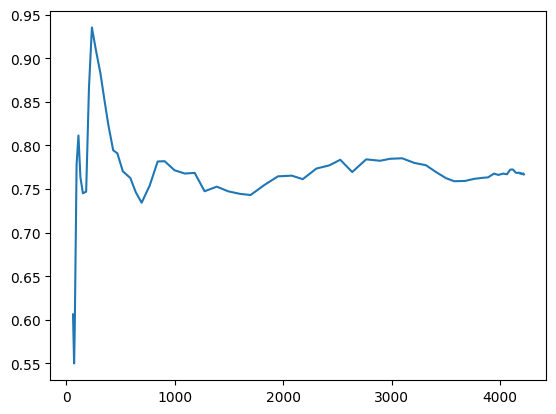

In [296]:
gain = same_race_return_bets(df_pred_table)
gain.plot()

In [297]:
# 期待値がthreshold以上の馬にかけた時の期待値
def race_return_bets(pred_table, n_samples=100, lower=50, min_threshold=0.5):
  gain = {}
  df = pred_table.copy()
  for i in range(n_samples):
    threshold = 1 * i / n_samples + min_threshold * (1-i/n_samples)
    df_bets = df[df["proba"] > threshold]
    n_bets = len(df_bets)
    money = -100 * n_bets + df_bets[df_bets["着順"] == 1]["return"].sum()
    if n_bets > lower:
      gain[n_bets] = (n_bets*100 + money) / (n_bets*100)
  return pd.Series(gain)

<AxesSubplot: >

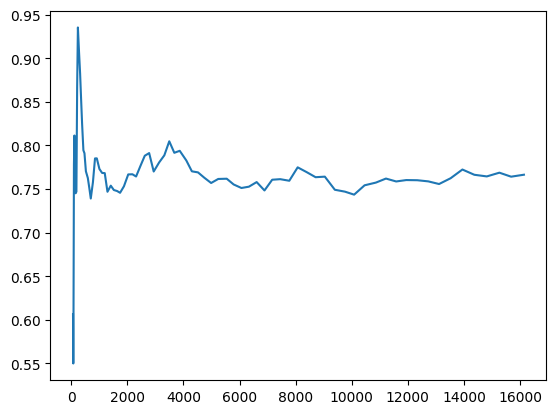

In [298]:
gain = race_return_bets(df_pred_table)
gain.plot()

In [299]:
# 人気が３位以内ではない馬にかけた時の期待値
def race_return_not_popular_bets(pred_table, n_samples=100, lower=50, min_threshold=0.5):
  gain = {}
  df = pred_table.copy()
  df = df[(df["人気"] !=1) & (df["人気"] !=2) & (df["人気"] !=3)]
  for i in range(n_samples):
    threshold = 1 * i / n_samples + min_threshold * (1-i/n_samples)
    df_bets = df[df["proba"] > threshold]
    n_bets = len(df_bets)
    money = -100 * n_bets + df_bets[df_bets["着順"] == 1]["return"].sum()
    if n_bets > lower:
      gain[n_bets] = (n_bets*100 + money) / (n_bets*100)
  return pd.Series(gain)

<AxesSubplot: >

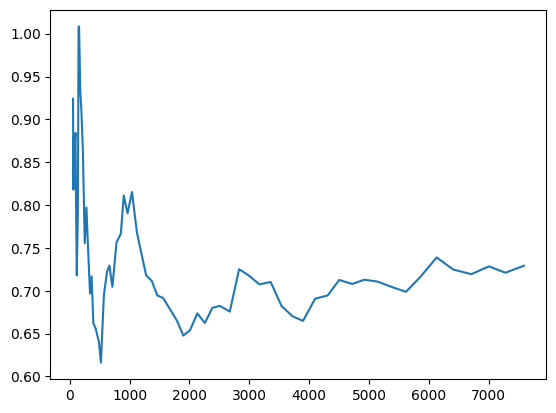

In [300]:
gain = race_return_not_popular_bets(df_pred_table)
gain.plot()

In [301]:
df1 = race_return_not_popular_bets(df_pred_table)


In [302]:
df = df_pred_table[(df_pred_table["人気"] !=1) & (df_pred_table["人気"] !=2) & (df_pred_table["人気"] !=3)]

In [303]:
df_bets = df[df["proba"] > 0.7]

In [304]:
df_bets

,着順,人気,馬番,proba,win,return
202103020201,12,4.0,2,0.719390,6.0,1640.0
202103020203,10,9.0,15,0.704102,14.0,200.0
202103020208,7,6.0,10,0.713711,4.0,2070.0
202103020211,10,6.0,16,0.712182,1.0,470.0
202103020302,1,4.0,12,0.794291,12.0,810.0
...,...,...,...,...,...,...
202310010304,6,5.0,5,0.704425,3.0,1610.0
202310010308,3,4.0,4,0.709690,5.0,520.0
202310010308,8,5.0,15,0.726679,5.0,520.0
202310010311,7,4.0,16,0.743701,2.0,220.0
